In [1]:
# -*- coding: utf-8 -*-

# ライブラリインポート

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import time
import os
import csv
import collections
from collections import Counter
from tqdm import tqdm
import re
import itertools
import seaborn

In [3]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rc("font", **font)

# データを読み込み

In [4]:
# df_all_fixの読み込み
df_all_1 = pd.read_csv("../output/df_csv/df_all_fix_1.csv", encoding = "utf-8")
df_all_2 = pd.read_csv("../output/df_csv/df_all_fix_2.csv", encoding = "utf-8")
print(df_all_1.columns)
print(df_all_1.shape)
print(df_all_2.columns)
print(df_all_2.shape)
df_all = df_all_1.append(df_all_2, ignore_index=True)
df_all = df_all.reset_index(drop=True)
# 不要列「Unnamed: 0」を削除
df_all = df_all.ix[:, 1:]
# データ確認
print(df_all.shape)
df_all.head(10)

Index(['Unnamed: 0', 'レンタルタイプ', '都道府県', '市区町村', '町域以下', '立地1_路線', '立地1_駅',
       '立地1_バス', '立地1_徒歩', '立地2_路線', '立地2_駅', '立地2_バス', '立地2_徒歩', '立地3_路線',
       '立地3_駅', '立地3_バス', '立地3_徒歩', '築年数', '地下', '地上', '階', '賃料', '管理費', '敷金',
       '礼金', '保証金', '敷引,償却費', '部屋数', 'D有無', 'K有無', 'L有無', 'S有無', '専有面積',
       '月額費用', '初期費用'],
      dtype='object')
(300001, 35)
Index(['Unnamed: 0', 'レンタルタイプ', '都道府県', '市区町村', '町域以下', '立地1_路線', '立地1_駅',
       '立地1_バス', '立地1_徒歩', '立地2_路線', '立地2_駅', '立地2_バス', '立地2_徒歩', '立地3_路線',
       '立地3_駅', '立地3_バス', '立地3_徒歩', '築年数', '地下', '地上', '階', '賃料', '管理費', '敷金',
       '礼金', '保証金', '敷引,償却費', '部屋数', 'D有無', 'K有無', 'L有無', 'S有無', '専有面積',
       '月額費用', '初期費用'],
      dtype='object')
(323993, 35)
(623994, 34)


/Users/kimiaki/Documents/virtualenv/py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()


,レンタルタイプ,都道府県,市区町村,町域以下,立地1_路線,立地1_駅,立地1_バス,立地1_徒歩,立地2_路線,立地2_駅,...,保証金,"敷引,償却費",部屋数,D有無,K有無,L有無,S有無,専有面積,月額費用,初期費用
0,賃貸アパート,東京,足立,西綾瀬４,東京メトロ千代田線,綾瀬駅,0,11,つくばエクスプレス,青井駅,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,24.00,26000.0,50000.0
1,賃貸アパート,東京,足立,小台２,日暮里・舎人ライナー,足立小台駅,0,17,ＪＲ高崎線,尾久駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.57,26000.0,52000.0
2,賃貸アパート,東京,足立,新田１,東京メトロ南北線,王子神谷駅,0,15,-,-,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,12.00,26500.0,50000.0
3,賃貸アパート,東京,足立,新田１,東京メトロ南北線,王子神谷駅,0,17,-,-,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.01,26500.0,50000.0
4,賃貸アパート,東京,足立,新田１,東京メトロ南北線,王子神谷駅,0,17,-,-,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.01,26500.0,50000.0
5,賃貸アパート,東京,足立,梅島２,東武伊勢崎線,梅島駅,0,9,東武伊勢崎線,西新井駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.00,28000.0,28000.0
6,賃貸アパート,東京,足立,梅島２,東武伊勢崎線,梅島駅,0,9,東武伊勢崎線,西新井駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.00,28000.0,28000.0
7,賃貸アパート,東京,足立,千住曙町,東京メトロ千代田線,北千住駅,0,15,京成本線,京成関屋駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.00,28000.0,56000.0
8,賃貸アパート,東京,足立,千住曙町,東京メトロ千代田線,北千住駅,0,15,東武伊勢崎線,牛田駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.00,28000.0,56000.0
9,賃貸アパート,東京,足立,千住曙町,東京メトロ千代田線,北千住駅,0,15,東武伊勢崎線,牛田駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.00,28000.0,56000.0


=> 623994件のデータが集まった。

# データ異常値確認

ref)https://pythondatascience.plavox.info/seaborn/%E6%A3%92%E3%82%B0%E3%83%A9%E3%83%95
ref Seaborn)https://pythondatascience.plavox.info/seaborn/%E6%A3%92%E3%82%B0%E3%83%A9%E3%83%95
ref pdPlot)https://qiita.com/hik0107/items/de5785f680096df93efa

In [5]:
df_all.describe()

,立地1_バス,立地1_徒歩,立地2_バス,立地2_徒歩,立地3_バス,立地3_徒歩,築年数,地下,地上,階,...,保証金,"敷引,償却費",部屋数,D有無,K有無,L有無,S有無,専有面積,月額費用,初期費用
count,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,...,6.239940e+05,6.239940e+05,623994.000000,623994.000000,623994.000000,623994.000000,623994.00000,623994.000000,6.239940e+05,6.239940e+05
mean,0.097789,7.677107,0.237286,11.617040,0.288450,13.752022,18.944024,-0.072092,5.763055,3.364542,...,1.816764e+03,3.725696e+03,1.303964,0.364951,0.819912,0.208978,0.01513,32.426672,1.029661e+05,1.955473e+05
std,1.160823,4.624772,2.037352,6.333507,2.359231,8.145962,14.175776,0.335441,5.610024,3.408785,...,2.899270e+04,2.499557e+04,0.615314,0.481417,0.384261,0.406579,0.12207,19.462988,7.370993e+04,1.063760e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,1.000000,-6.000000,...,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.00000,0.100000,1.780000e+04,0.000000e+00
25%,0.000000,4.000000,0.000000,8.000000,0.000000,9.000000,7.000000,0.000000,2.000000,2.000000,...,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,0.00000,20.720000,6.900000e+04,7.400000e+04
50%,0.000000,7.000000,0.000000,11.000000,0.000000,14.000000,17.000000,0.000000,4.000000,2.000000,...,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,0.00000,26.000000,8.700000e+04,1.340000e+05
75%,0.000000,10.000000,0.000000,15.000000,0.000000,19.000000,29.000000,0.000000,7.000000,4.000000,...,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,0.000000,0.00000,40.000000,1.150000e+05,2.000000e+05
max,35.000000,472.000000,50.000000,70.000000,65.000000,222.000000,99.000000,0.000000,60.000000,60.000000,...,5.138000e+06,2.800000e+06,10.000000,1.000000,1.000000,1.000000,1.00000,679.200000,3.500000e+06,4.850097e+09


=> バス65分、地上60階、10部屋、はなんとなくありそうだが、<br>
   徒歩472分、築年数99年、地下9階、専有面積679m2、初期費用48億円、は自分の感覚的になさそうなので、ミスデータか確認してみる。

## 徒歩

## 築年数

## 専有面積

## 初期費用

In [37]:
# df_all[df_all["立地1_徒歩"] == max(df_all["立地1_徒歩"])]
max(df_all[df_all["立地1_徒歩"] < 472]["立地1_徒歩"])

117

In [34]:
max(df_all[df_all["立地1_徒歩"] < 117]["立地1_徒歩"])

57

In [36]:
max(df_all[df_all["立地1_徒歩"] < 57]["立地1_徒歩"])

48

=> 徒歩が

# データの傾向を確認

★基本は統計量などを可視化などで把握していく。

以下を確認する。<br>
①23区ごとの物件数<br>
②徒歩と物件数<br>
③レンタルタイプごとの物件数<br>
④23区ごとの徒歩分布<br>
⑤23区ごとの築年数分布<br>
⑥徒歩と月額費用の分布<br>
⑦専有面積と月額費用の分布<br>
⑧路線数と月額費用の分布

## ①23区ごとの物件数

## ②徒歩と物件数

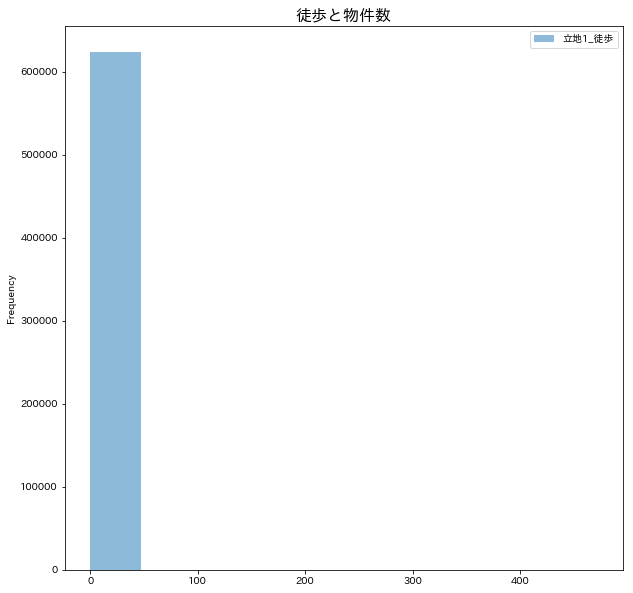

In [11]:
ax = df_all.plot(y=["立地1_徒歩"], alpha=0.5, figsize=(10,10), kind="hist", bins=)
plt.title("徒歩と物件数", size=16)
plt.show()

## ③レンタルタイプごとの物件数

## ④23区ごとの徒歩分布

## ⑤23区ごとの築年数分布

## ⑥徒歩と月額費用の分布

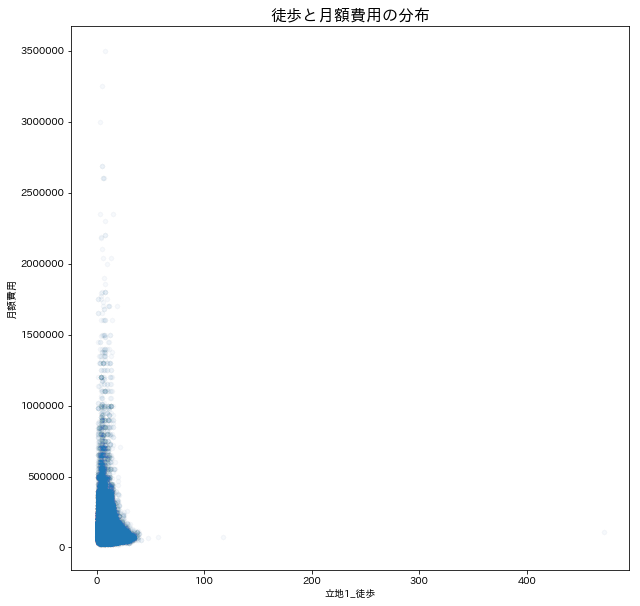

In [13]:
df_all.plot.scatter(x="立地1_徒歩", y="月額費用", alpha=0.01, figsize=(10,10))
plt.title("徒歩と月額費用の分布", size=16)
plt.show()

## ⑦専有面積と月額費用の分布

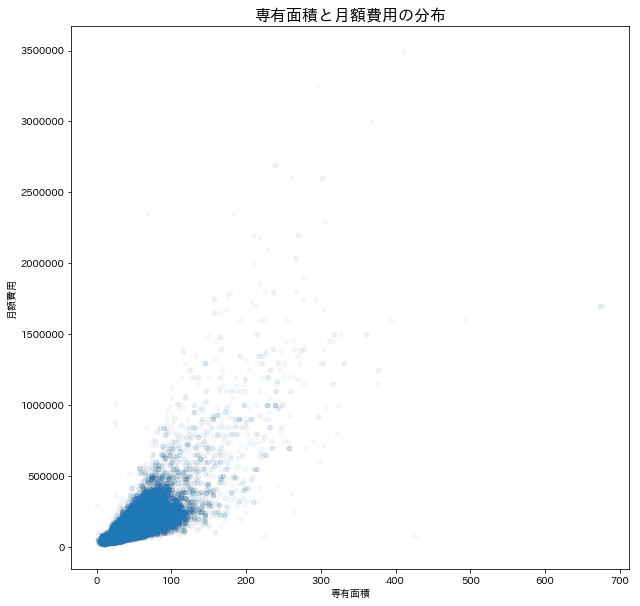

In [12]:
df_all.plot.scatter(x="専有面積", y="月額費用", alpha=0.01, figsize=(10, 10))
plt.title("専有面積と月額費用の分布", size=16)
plt.show()

# 予測モデル作成

次のモデルを作成してみる。<br>
①ロジスティック回帰
②XGBoost
③DNN

# お買い物物件を探す